## Energy consumption in Toulouse as in Bueno et al. 2012

The goal of this notebook is to recreate the results for Toulouse as shown in https://gmd.copernicus.org/articles/5/433/2012/

In [4]:
import sys
from pathlib import Path
import f90nml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

In [5]:
THIS_DIR = Path.cwd()
PROJ_DIR = THIS_DIR.parents[1]
sys.path.append(str(PROJ_DIR / 'tools'))
from helpers import run_teb, load_txt, get_date_params
path_to_teb_exe = PROJ_DIR / 'build' / 'driver'

In [6]:
# Run TEB
run_teb(THIS_DIR, path_to_teb_exe, None)

Running case: BUENO_2012


In [7]:
def read_teb_outputs(THIS_DIR):

    # Read TEB outputs
    path_to_case_dir = THIS_DIR
    case_nml = path_to_case_dir / 'input.nml'
    start, freq = get_date_params(case_nml)

    # The start time in TEB is always given in UTC so we convert to local time with local_tz
    df_bem = load_txt(path_to_case_dir / 'output', start, freq, local_tz='Europe/Paris')

    # Resample and subset to same period used in paper
    df_bem = df_bem.resample('1D').mean()
    simulation_period = df_bem.loc['2004-12-19' : '2005-02-17'].index
    df_bem = df_bem.loc[simulation_period]
    return df_bem

df_bem = read_teb_outputs(THIS_DIR)

In [8]:
def read_obs(THIS_DIR, date_range):
    dateparse = lambda x, y: datetime.strptime(f"{x} {y}",'%d/%m/%Y %H:%M:%S.%f')

    df_obs = pd.read_csv(THIS_DIR / "obs" / "qf_1800.dat", index_col=['datetime'], names=['date', 'time', 'electric_consumption', 'traffic', 'gas_consumption'], 
                    parse_dates={'datetime': ['date', 'time']}, date_parser=dateparse, delim_whitespace=True)

    df_obs = df_obs.resample('1D').mean().tz_localize('Europe/Paris').loc[date_range]
    return df_obs

df_obs = read_obs(THIS_DIR, df_bem.index)

/tmp/ipykernel_1294/808128476.py:4: FutureWarning: 
        Use pd.to_datetime instead.

  df_obs = pd.read_csv(THIS_DIR / "obs" / "qf_1800.dat", index_col=['datetime'], names=['date', 'time', 'electric_consumption', 'traffic', 'gas_consumption'],


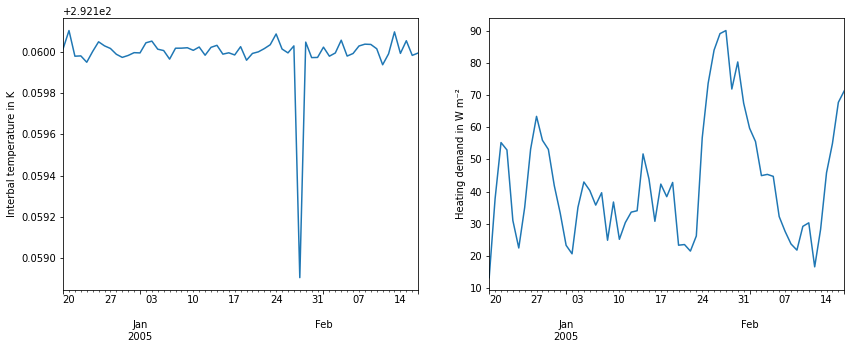

In [9]:
# Plot internal temperature and buiding energy demand to check if envelope is leaky with current parameters
fig, ax = plt.subplots(1,2, figsize=(14,5))
quantity_name = 'TI_BLD'
df_bem[quantity_name].plot(ax=ax[0])
ax[0].set_ylabel("Interbal temperature in K")

quantity_name = 'HVAC_HEAT'
df_bem[quantity_name].plot(ax=ax[1])
ax[1].set_ylabel("Heating demand in W m⁻²");

In [10]:
# Define some funcs used for the comparisons
def compute_errors(df_x, df_y, vs):
    diff = df_x - df_y
    mbe = diff.mean()
    rmse = np.sqrt((diff**2).mean())
    print(f"RMSE: {round(rmse, 1)} W m⁻² (urb) vs {vs[0]} W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7")
    print(f"MBE: {round(mbe, 1)} W m⁻² (urb) vs {vs[1]} W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7")
    
def plot_res(df_sim, df_obs, label, vs, fpath_ref, internal_gains):
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    df_sim.plot(ax=ax[0], c='r')
    df_obs.plot(ax=ax[0], c='k', marker="o", linestyle='')
    ax[0].axhline(internal_gains, lw=2)
    ax[0].set_xlabel('Datetime')
    ax[0].set_ylabel(label)
    ax[0].legend(['TEB', 'Observed', f'Internal gains = {internal_gains} W m⁻²']);
    ax[0].set_ylim([0, 100]);
    ax[1].imshow(plt.imread(fpath_ref))
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    ax[1].set_title("FIg. 9, page 11\nhttps://gmd.copernicus.org/articles/5/433/2012/")
    
    compute_errors(df_sim, df_obs, vs=vs)

def compute_consumption(df_bem, internal_heat_gains_electric, internal_heat_gains_gas):
    # Electric consumption
    frac_electric_over_gas_heating = 2/3 # page 8 https://link.springer.com/article/10.1007/s10546-011-9620-6
    building_density = 0.68 # page 8 https://link.springer.com/article/10.1007/s10546-011-9620-6
    df_bem_electric = df_bem['HVAC_HEAT'] * frac_electric_over_gas_heating * building_density + internal_heat_gains_electric
    # Gas consumption
    df_bem_gas = df_bem['HVAC_HEAT'] * (1 - frac_electric_over_gas_heating) * building_density + internal_heat_gains_gas

    return df_bem_electric, df_bem_gas

In [11]:
average_internal_heat_gain = 38.6 # page 7 https://link.springer.com/article/10.1007/s10546-011-9620-6
heat_gain_electric_over_gas_fraction = 0.7 # page 7 https://link.springer.com/article/10.1007/s10546-011-9620-6
heat_gain_gas_fraction = 1 - heat_gain_electric_over_gas_fraction
heat_gains_electric = round(average_internal_heat_gain * heat_gain_electric_over_gas_fraction, 1)
heat_gains_gas = round(average_internal_heat_gain * heat_gain_gas_fraction, 1)
df_bem_electric, df_bem_gas = compute_consumption(df_bem, heat_gains_electric, heat_gains_gas)

RMSE: 13.9 W m⁻² (urb) vs 5.1 W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7
MBE: 12.8 W m⁻² (urb) vs -2.8 W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7


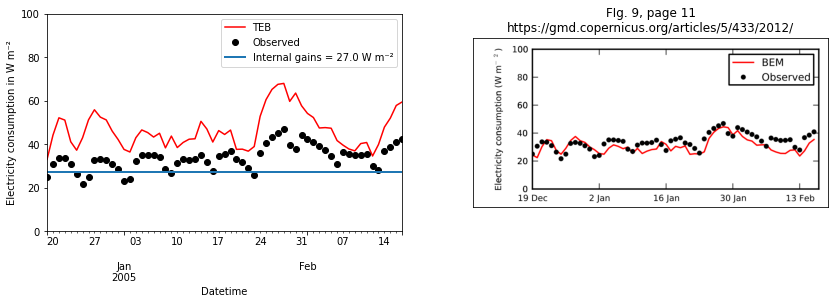

In [12]:
label = 'Electricity consumption in W m⁻²'
vs = (5.1, -2.8)
fpath_ref = THIS_DIR / "obs" / "electric.png"

plot_res(df_bem_electric, df_obs['electric_consumption'], label, vs, fpath_ref, heat_gains_electric)

RMSE: 4.3 W m⁻² (urb) vs 7.4 W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7
MBE: -3.7 W m⁻² (urb) vs -6.0 W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7


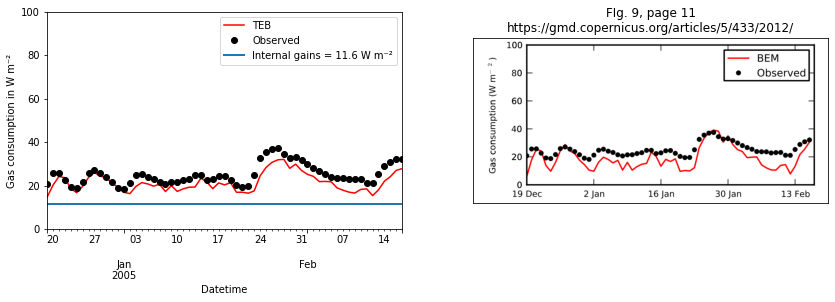

In [13]:
label = 'Gas consumption in W m⁻²'
vs = (7.4, -6.0)
fpath_ref = THIS_DIR / "obs" / "gas.png"

plot_res(df_bem_gas, df_obs['gas_consumption'], label, vs, fpath_ref, heat_gains_gas)

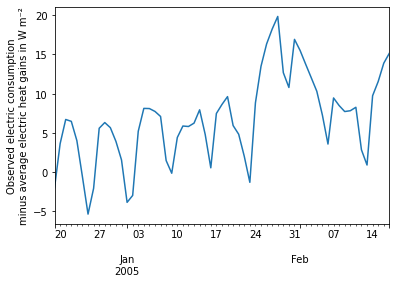

In [14]:
(df_obs['electric_consumption'] - heat_gains_electric).plot()
plt.ylabel("Observed electric consumption\nminus average electric heat gains in W m⁻²");

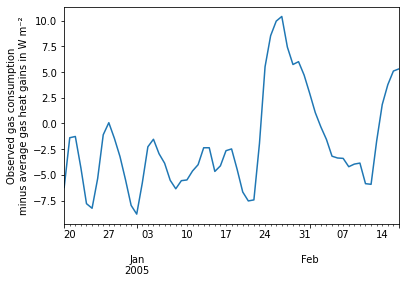

In [15]:
(df_obs['gas_consumption'] - heat_gains_electric).plot()
plt.ylabel("Observed gas consumption\nminus average gas heat gains in W m⁻²");